### Analyze immune cells from CD45+ enriched gonadal samples

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os

import sys

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './final-figures/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
backcall            0.2.0
cairo               1.20.0
cffi                1.14.5
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
google              NA
h5py                2.10.0
highs_wrapper       NA
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.35.0
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.52.0
numexpr             2.7.2
numpy               1.19.5
packaging           20.9
pandas              1.2.2
parso               0.8.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.16
psutil      

'/home/jovyan/my-conda-envs/scanpy_env/bin/python'

#### Load cellranger output of enriched samples

In [2]:
path_to_data = '/nfs/users/nfs_l/lg18/team292/lg18/gonads/data/scRNAseq/FCA/rawdata/'

In [3]:
metadata = pd.read_csv(path_to_data + 'meta_2sex.csv', index_col = 0)
metadata['process'].value_counts()

total    19
CD45+    11
CD45-    10
Name: process, dtype: int64

In [4]:
# Select process = CD45+ 
metadata_enriched = metadata[metadata['process'] == 'CD45+']
metadata_enriched

individual location  stage     sex study batch_collection  \
sample                                                                     
FCA_GND8047884        F81    Gonad    8.8  female   FCA                A   
FCA_GND8125922        F86    Gonad    7.5  female   FCA                B   
FCA_GND8125924        F87    Gonad   11.0  female   FCA                B   
FCA_GND8103049        F83    Gonad   17.0  female   FCA                C   
FCA_GND8103052        F84    Gonad    9.0  female   FCA            Cpoor   
FCA_GND8622627        F91    Gonad   11.0  female   FCA                E   
FCA_GND8715407        F96    Gonad   14.0  female   FCA                F   
FCA_GND8289579        F88    Gonad   11.0    male   FCA                D   
FCA_GND8622629        F93    Gonad    6.0    male   FCA                E   
FCA_GND8622631        F94    Gonad   12.0    male   FCA                E   
FCA_GND8784459        F99    Gonad    8.6  female   FCA                H   

               process  cryopreserved  
sample                                 
FCA_GND8047884   CD45+          False  
FCA_GND8125922   CD45+          False  
FCA_GND8125924   CD45+          False  
FCA_GND8103049   CD45+          False  
FCA_GND8103052   CD45+          False  
FCA_GND8622627   CD45+          False  
FCA_GND8715407   CD45+          False  
FCA_GND8289579   CD45+          False  
FCA_GND8622629   CD45+          False  
FCA_GND8622631   CD45+          False  
FCA_GND8784459   CD45+          False

In [5]:
metadata_enriched['stage'] = metadata_enriched['stage'].astype('str')
plotmeta = list(metadata_enriched.columns)
plotmeta.append('sample')
print('Number of samples: ', metadata_enriched.index.size)

Number of samples:  11


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Filter: 
 * cells (< 10 genes)
 * genes (< 3 cells)

Quantify: 
 * % mitochondrial genes; 
 * total counts

In [6]:
holder = []
for sample in metadata_enriched.index:
    print(sample)
    # Load 10x data as AnnData
    holder.append(sc.read_10x_mtx(path_to_data + sample + '/filtered_feature_bc_matrix/',cache=True)) 
    # Set names of observation as sample + _ + barcode/probe
    holder[-1].obs_names = [sample+'_'+i.split('-')[0] for i in holder[-1].obs_names]
    # Filer genes expressed in less than 3 cells
    sc.pp.filter_genes(holder[-1], min_cells=3)
    # Filer cells with less than 10 genes expressed
    sc.pp.filter_cells(holder[-1], min_genes=150)
    # add in metadata
    holder[-1].obs['sample'] = sample
    for val in metadata_enriched.columns:
        holder[-1].obs[val] = metadata_enriched[val][sample]
    # Extract mitochondial genes
    mito_genes = [name for name in holder[-1].var_names if name.startswith('MT-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
        holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
    print('Total number of cells: {:d}'.format(holder[-1].n_obs))
    print('Total number of genes: {:d}'.format(holder[-1].n_vars))

FCA_GND8047884
... reading from cache file cache/nfs-users-nfs_l-lg18-team292-lg18-gonads-data-scRNAseq-FCA-rawdata-FCA_GND8047884-filtered_feature_bc_matrix-matrix.h5ad
filtered out 15025 genes that are detected in less than 3 cells
filtered out 3 cells that have less than 150 genes expressed
Total number of cells: 1322
Total number of genes: 18513
FCA_GND8125922
... reading from cache file cache/nfs-users-nfs_l-lg18-team292-lg18-gonads-data-scRNAseq-FCA-rawdata-FCA_GND8125922-filtered_feature_bc_matrix-matrix.h5ad
filtered out 12344 genes that are detected in less than 3 cells
filtered out 39 cells that have less than 150 genes expressed
Total number of cells: 4825
Total number of genes: 21194
FCA_GND8125924
... reading from cache file cache/nfs-users-nfs_l-lg18-team292-lg18-gonads-data-scRNAseq-FCA-rawdata-FCA_GND8125924-filtered_feature_bc_matrix-matrix.h5ad
filtered out 14513 genes that are detected in less than 3 cells
filtered out 103 cells that have less than 150 genes expresse

In [7]:
# confirm N samples
print(len(holder))
# merge datasets
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)
# copy of this matrix in Compressed Sparse Row format
adata.X = adata.X.tocsr()
adata

11


AnnData object with n_obs × n_vars = 36400 × 24706 
    obs: 'batch', 'batch_collection', 'cryopreserved', 'individual', 'location', 'n_counts', 'n_genes', 'percent_mito', 'process', 'sample', 'sex', 'stage', 'study'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'n_cells-8', 'gene_ids-9', 'feature_types-9', 'n_cells-9', 'gene_ids-10', 'feature_types-10', 'n_cells-10'

#### Quality Control plots

Plot distributions of the values n_genes, n_counts and percent_mito and filter out cells with less than 300 genes expressed, genes expressed in less than 3 cells, cells with more than 20% of mitochondrial genes 

In [8]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True, save='.pdf', show=False)
sc.pl.scatter(adata, x='n_counts', y='percent_mito', save='_numi_vs_mito.pdf', show=False)
sc.pl.scatter(adata, x='n_counts', y='n_genes', save='_numi_vs_ngenes.pdf', show=False)

... storing 'batch_collection' as categorical
... storing 'individual' as categorical
... storing 'location' as categorical
... storing 'process' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'stage' as categorical
... storing 'study' as categorical
... storing 'gene_ids-0' as categorical
... storing 'feature_types-0' as categorical
... storing 'gene_ids-1' as categorical
... storing 'feature_types-1' as categorical
... storing 'gene_ids-2' as categorical
... storing 'feature_types-2' as categorical
... storing 'gene_ids-3' as categorical
... storing 'feature_types-3' as categorical
... storing 'gene_ids-4' as categorical
... storing 'feature_types-4' as categorical
... storing 'gene_ids-5' as categorical
... storing 'feature_types-5' as categorical
... storing 'gene_ids-6' as categorical
... storing 'feature_types-6' as categorical
... storing 'gene_ids-7' as categorical
... storing 'feature_types-7' as categorical
... storing 'gene_id

In [9]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], groupby='individual', jitter=0.4, save='_perindividual.pdf', show=False)

In [10]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 36400
Total number of genes: 24706


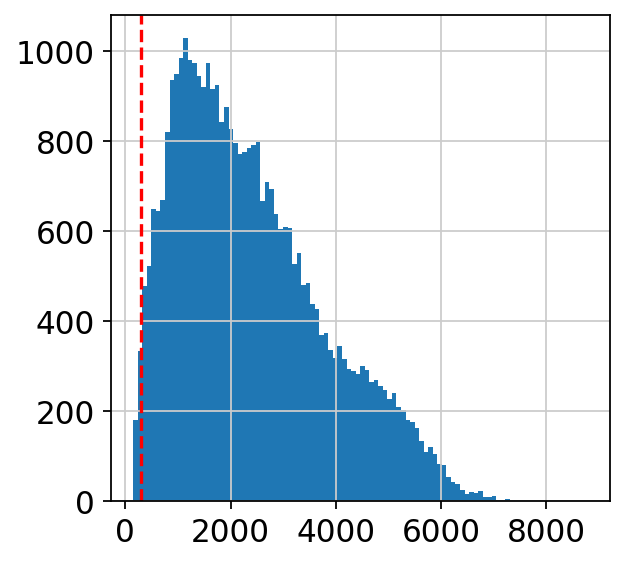

In [11]:
# Filter out cells with few genes 
import matplotlib.pyplot as plt
plt.hist(adata.obs['n_genes'], bins = 100)
plt.axvline(300, linestyle = '--', color = 'red')

In [12]:
sc.pp.filter_cells(adata, min_genes=300) # New threshold to match Luz

filtered out 405 cells that have less than 300 genes expressed


In [13]:
sc.pp.filter_genes(adata, min_cells=3)

filtered out 5 genes that are detected in less than 3 cells


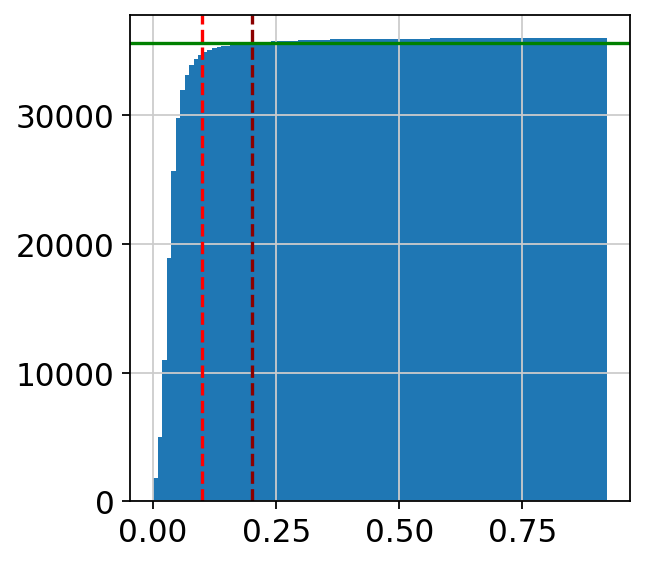

In [14]:
# Filter out cells with a high percentage of mitochondrial genes 
plt.hist(adata.obs['percent_mito'], bins = 100, cumulative=True)
plt.axvline(0.1, linestyle = '--', color = 'red')
plt.axvline(0.2, linestyle = '--', color = 'darkred')
plt.axhline(adata.n_obs*0.99, linestyle = '-', color = 'green')

In [15]:
# >20%
adata = adata[adata.obs['percent_mito'] < 0.2, :]

In [16]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['individual'].values.describe()

Total number of cells: 35619
Total number of genes: 24701


counts     freqs
categories                  
F81           1303  0.036582
F83           4389  0.123221
F84           2806  0.078778
F86           4770  0.133917
F87           2976  0.083551
F88           4578  0.128527
F91           2548  0.071535
F93           3179  0.089250
F94           3442  0.096634
F96           4960  0.139252
F99            668  0.018754

#### Save raw data

In [17]:
adata.raw = adata.copy()

#### Per genes analysis: identify genes behaving like known cell cycle genes

In [18]:
bdata = adata.copy()
# Normalize total counts per cell
sc.pp.normalize_per_cell(bdata, counts_per_cell_after=1e4)
# Logarithmize the data matrix
sc.pp.log1p(bdata)

normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [19]:
# Extract highly variable genes
sc.pp.highly_variable_genes(bdata)
highly_variable_genes = bdata.var["highly_variable"]
bdata = bdata[:, highly_variable_genes]

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [20]:
# Traspose matrix for a GENE-centered analysis
bdata = bdata.copy().T

In [21]:
bdata.X.shape

(3130, 35619)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:06)


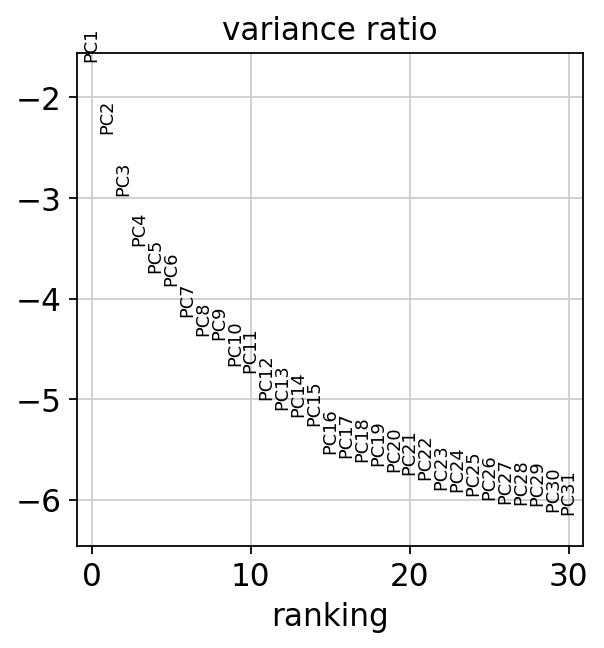

In [22]:
# Scale data to unit variance and zero mean
sc.pp.scale(bdata, max_value=10)

# Scatter plot in PCA coordinates
sc.tl.pca(bdata)
bdata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
# Plot the variance ratio
sc.pl.pca_variance_ratio(bdata, log=True, save='_ccg_identification.pdf')

In [23]:
num_pcs = 22
# Compute a neighborhood graph of observations
sc.pp.neighbors(bdata, n_pcs=num_pcs)
# Embed the neighborhood graph using UMAP
sc.tl.umap(bdata)
# Cluster GENES into subgroups using louvain: resolution < 1 to find less clusters
sc.tl.louvain(bdata, resolution=1)

computing neighbors
    using 'X_pca' with n_pcs = 22
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


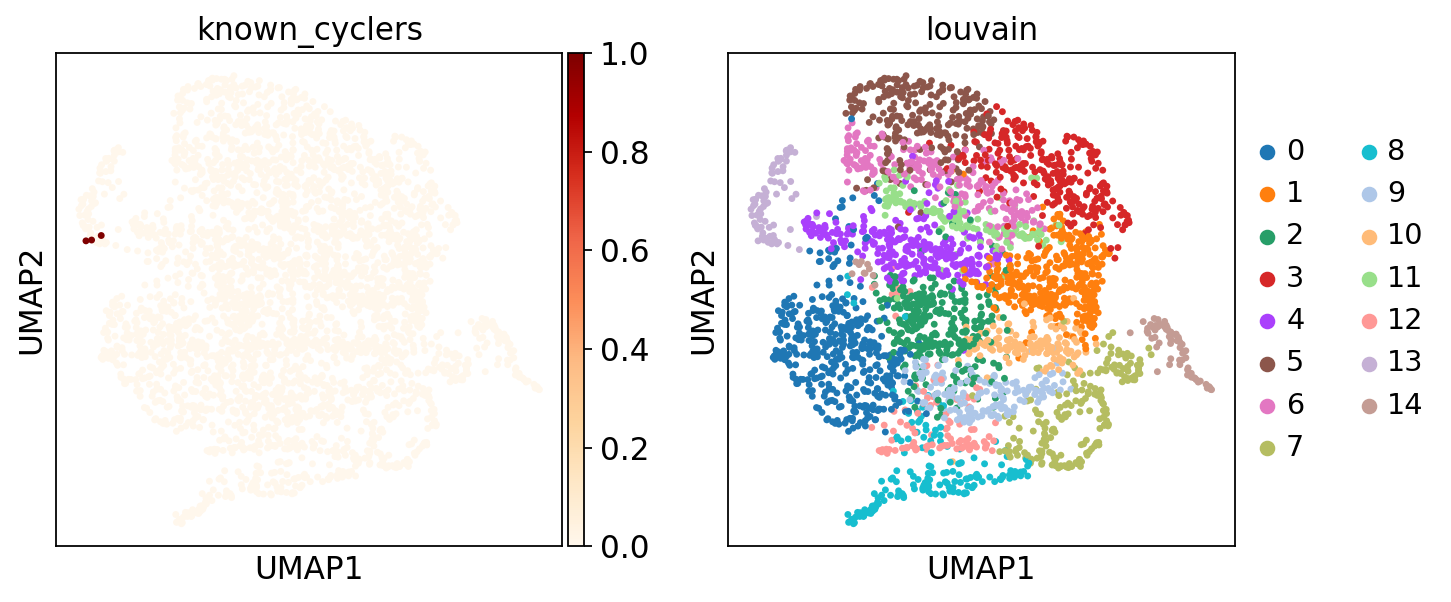

CDK1     13
MKI67    13
CCNB2    13
Name: louvain, dtype: category
Categories (15, object): [0, 1, 2, 3, ..., 11, 12, 13, 14]


In [24]:
# Locate ccs cluster
bdata.obs['known_cyclers'] = [i in ['CDK1','MKI67','CCNB2','PCNA'] for i in bdata.obs_names]
sc.pl.umap(bdata, color=['known_cyclers', 'louvain'], color_map='OrRd',save='_ccg_identification.pdf')
print(bdata.obs.loc[[i in ['CDK1','MKI67','CCNB2','PCNA'] for i in bdata.obs_names],'louvain'])

In [25]:
ccgs_cl = bdata.obs.loc['CDK1',['louvain']][0]
print("Cell cycle genes cluster is "+ccgs_cl)

Cell cycle genes cluster is 13


#### Remove cell cycle genes

In [26]:
# Add unstructured dict-like annotation for ccgs
adata.uns['ccgs'] = list(bdata.obs[bdata.obs['louvain']==ccgs_cl].index)

In [27]:
# Remove cc genes
print('Total number of genes before ccg filter: {:d}'.format(adata.n_vars))
adata = adata[:,[i not in adata.uns['ccgs'] for i in adata.var_names]]
print('Total number of genes after ccg filter: {:d}'.format(adata.n_vars))

Total number of genes before ccg filter: 24701
Total number of genes after ccg filter: 24625


In [28]:
# Move plots
MovePlots('ccg_identification','ccg_identification')

#### Normalize per cell and log-transform

After removing unwanted cells and genes from the dataset, the next step is to normalize the data. By default, we employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result.

In [29]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:04): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


#### Filter HVGs in bdata and compute PCA with them

In [30]:
bdata = adata.copy()
sc.pp.highly_variable_genes(bdata, min_mean=0.0125, max_mean=3, min_disp=0.5)
for col in ['highly_variable','means', 'dispersions', 'dispersions_norm']:
    adata.var[col] = bdata.var[col]
bdata = bdata[:, bdata.var['highly_variable']]
print('Total number of cells: {:d}'.format(bdata.n_obs))
print('Total number of genes: {:d}'.format(bdata.n_vars))

extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Total number of cells: 35619
Total number of genes: 3102


In [31]:
sc.pp.scale(bdata, max_value=10)
sc.tl.pca(bdata, svd_solver='arpack', n_comps=50)

/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)


#### Transfer PCA coordinates to the main data

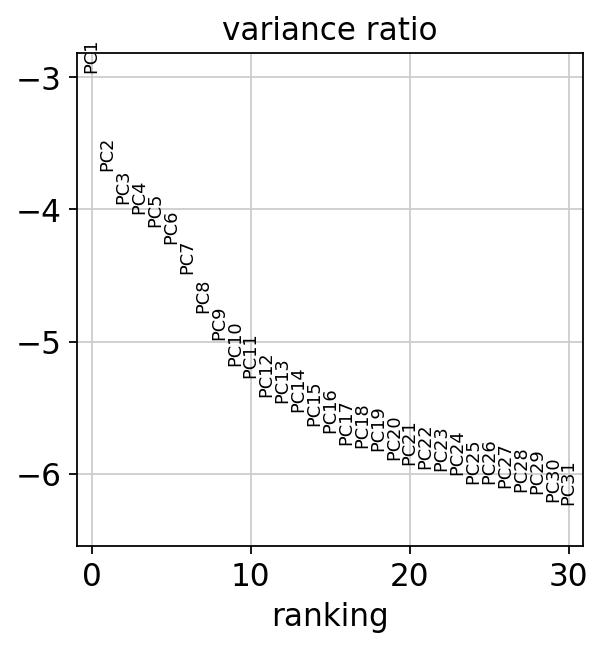

In [32]:
#fill NaNs with False so that subsetting to HVGs is possible
adata.var['highly_variable'].fillna(value=False, inplace=True)
adata.obsm['X_pca'] = bdata.obsm['X_pca'].copy()
adata.uns['pca'] = bdata.uns['pca'].copy()
adata.varm['PCs'] = np.zeros(shape=(adata.n_vars, 50))
adata.varm['PCs'][adata.var['highly_variable']] = bdata.varm['PCs']
sc.pl.pca_variance_ratio(adata, log=True, save='.pdf')

#### Save

In [33]:
# format some metadata
# PCW as numerical
adata.obs['PCW'] = adata.obs.stage.astype('float').tolist()
# source: L=london; N=newcastle
adata.obs['sample_source'] = 'N'
idx = np.array(['Hrv' in i for i in adata.obs['individual']])
adata.obs.at[ idx, 'sample_source']  = 'L'

In [34]:
adata.write('/nfs/team292/vl6/immune_fetal_gonads/enriched_samples_M1preprocessing.h5ad')

... storing 'sample_source' as categorical


#### Visualize data

In [35]:
n_pcs = 24
sc.pp.neighbors(adata, n_pcs = n_pcs)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 24
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:23)


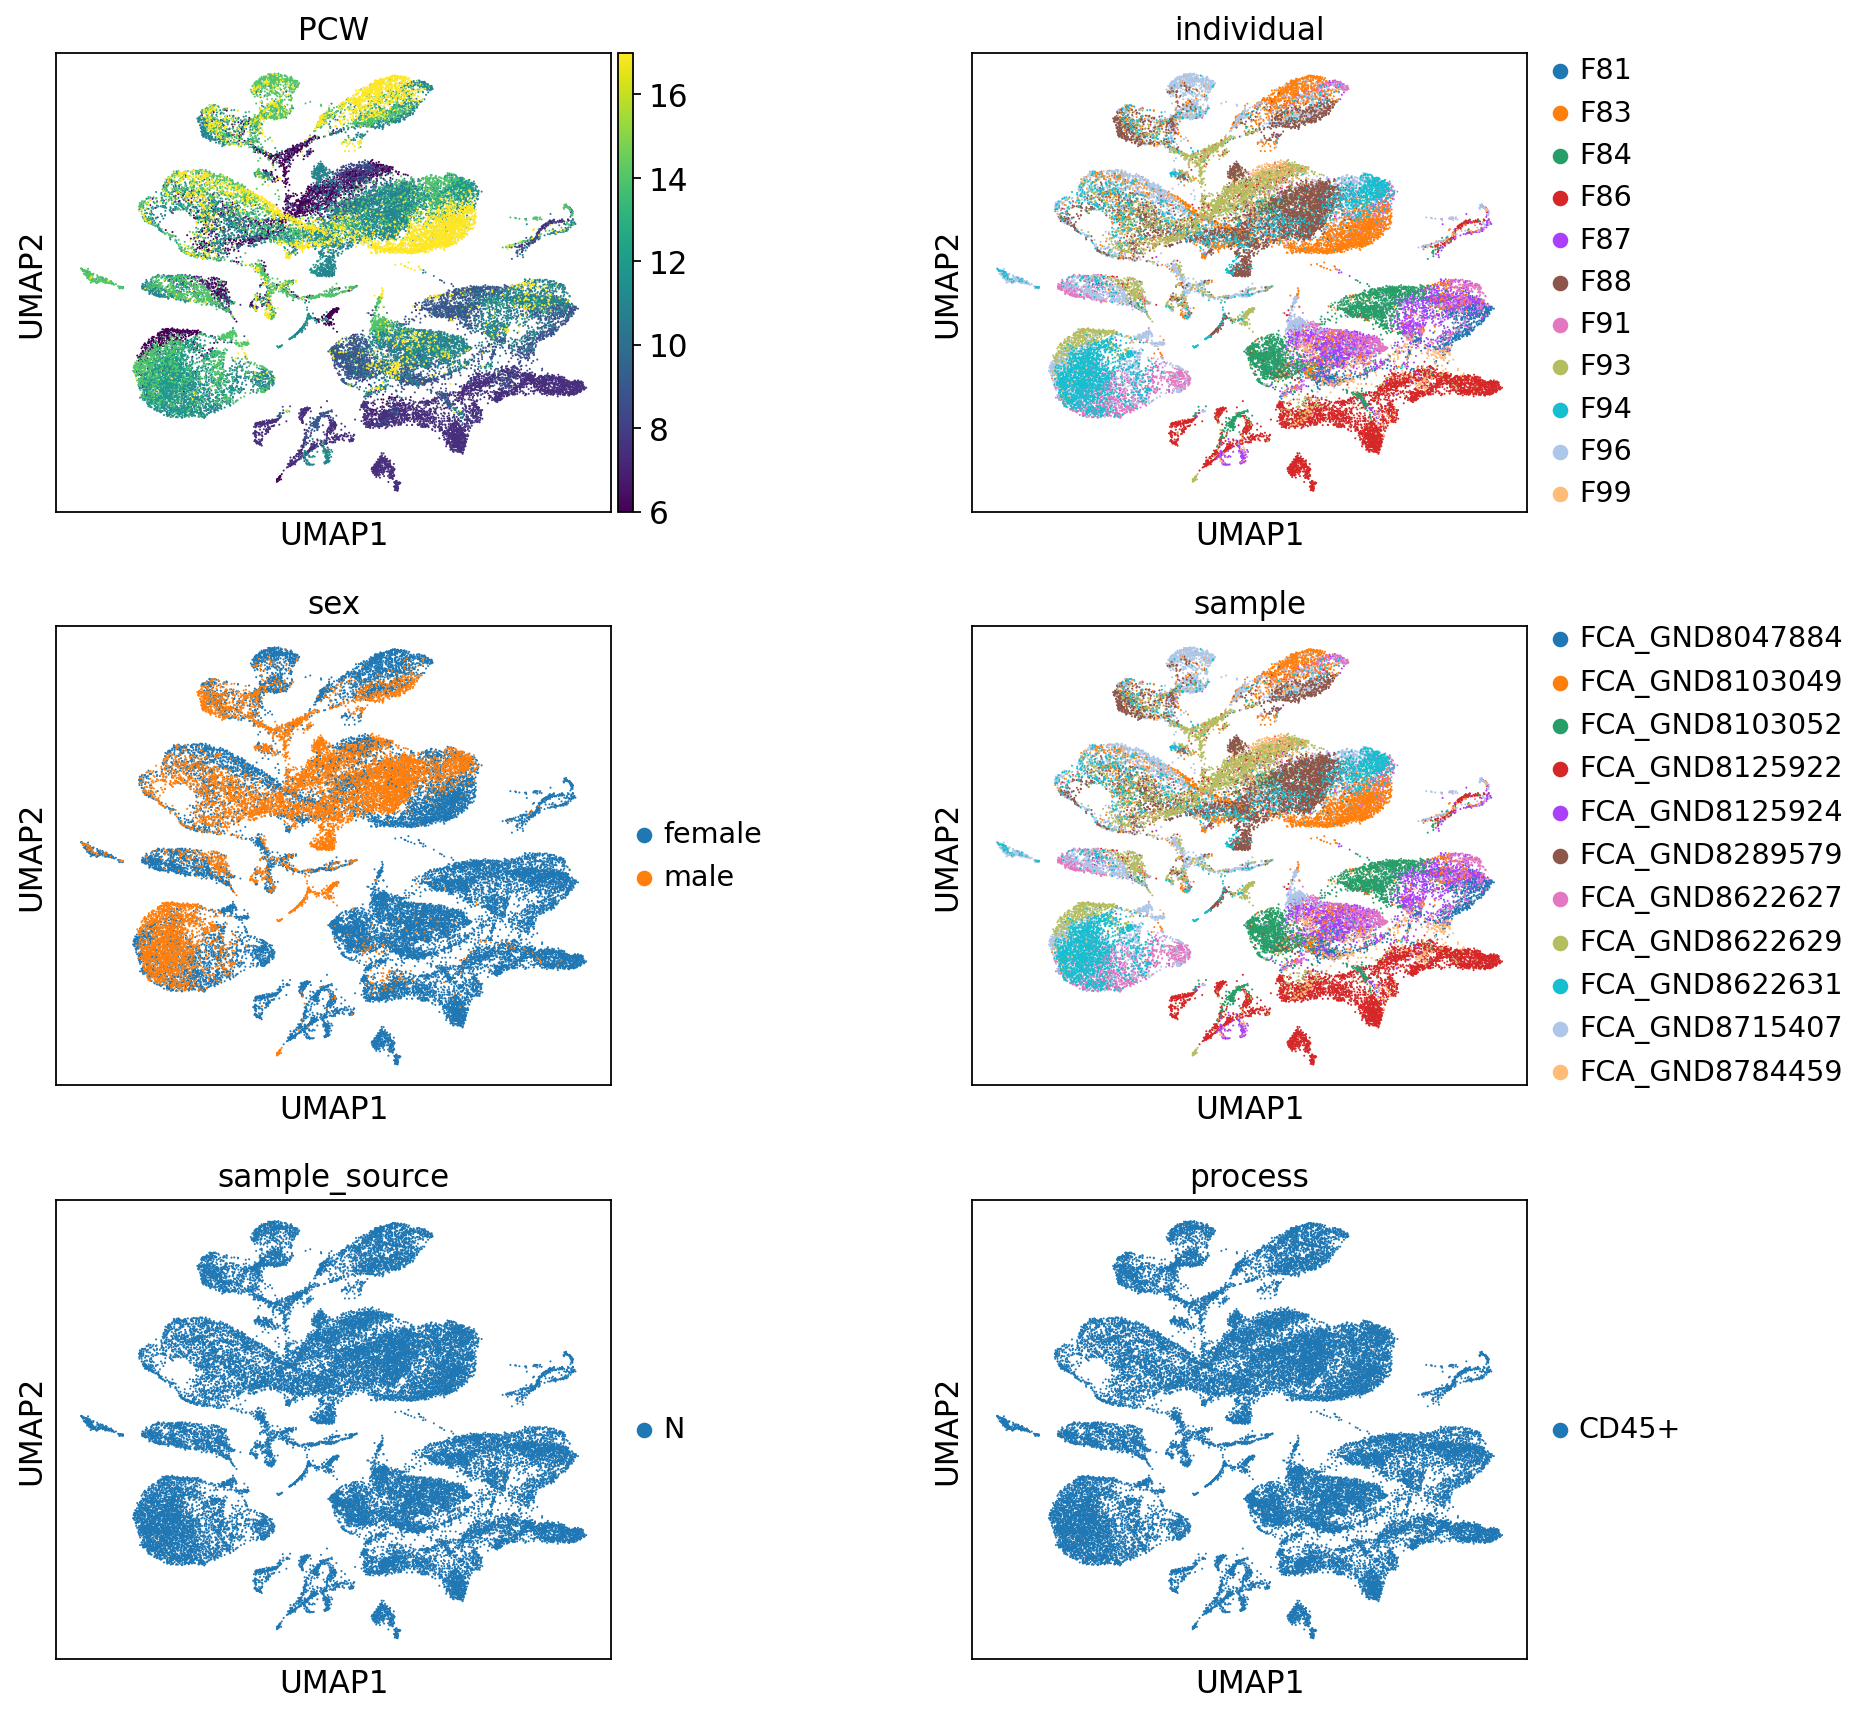

In [36]:
sc.pl.umap(adata, color=['PCW', 'individual', 'sex', 'sample', 
                         'sample_source', 'process'], save='_predoublet.pdf', ncols = 2, wspace = 0.5)

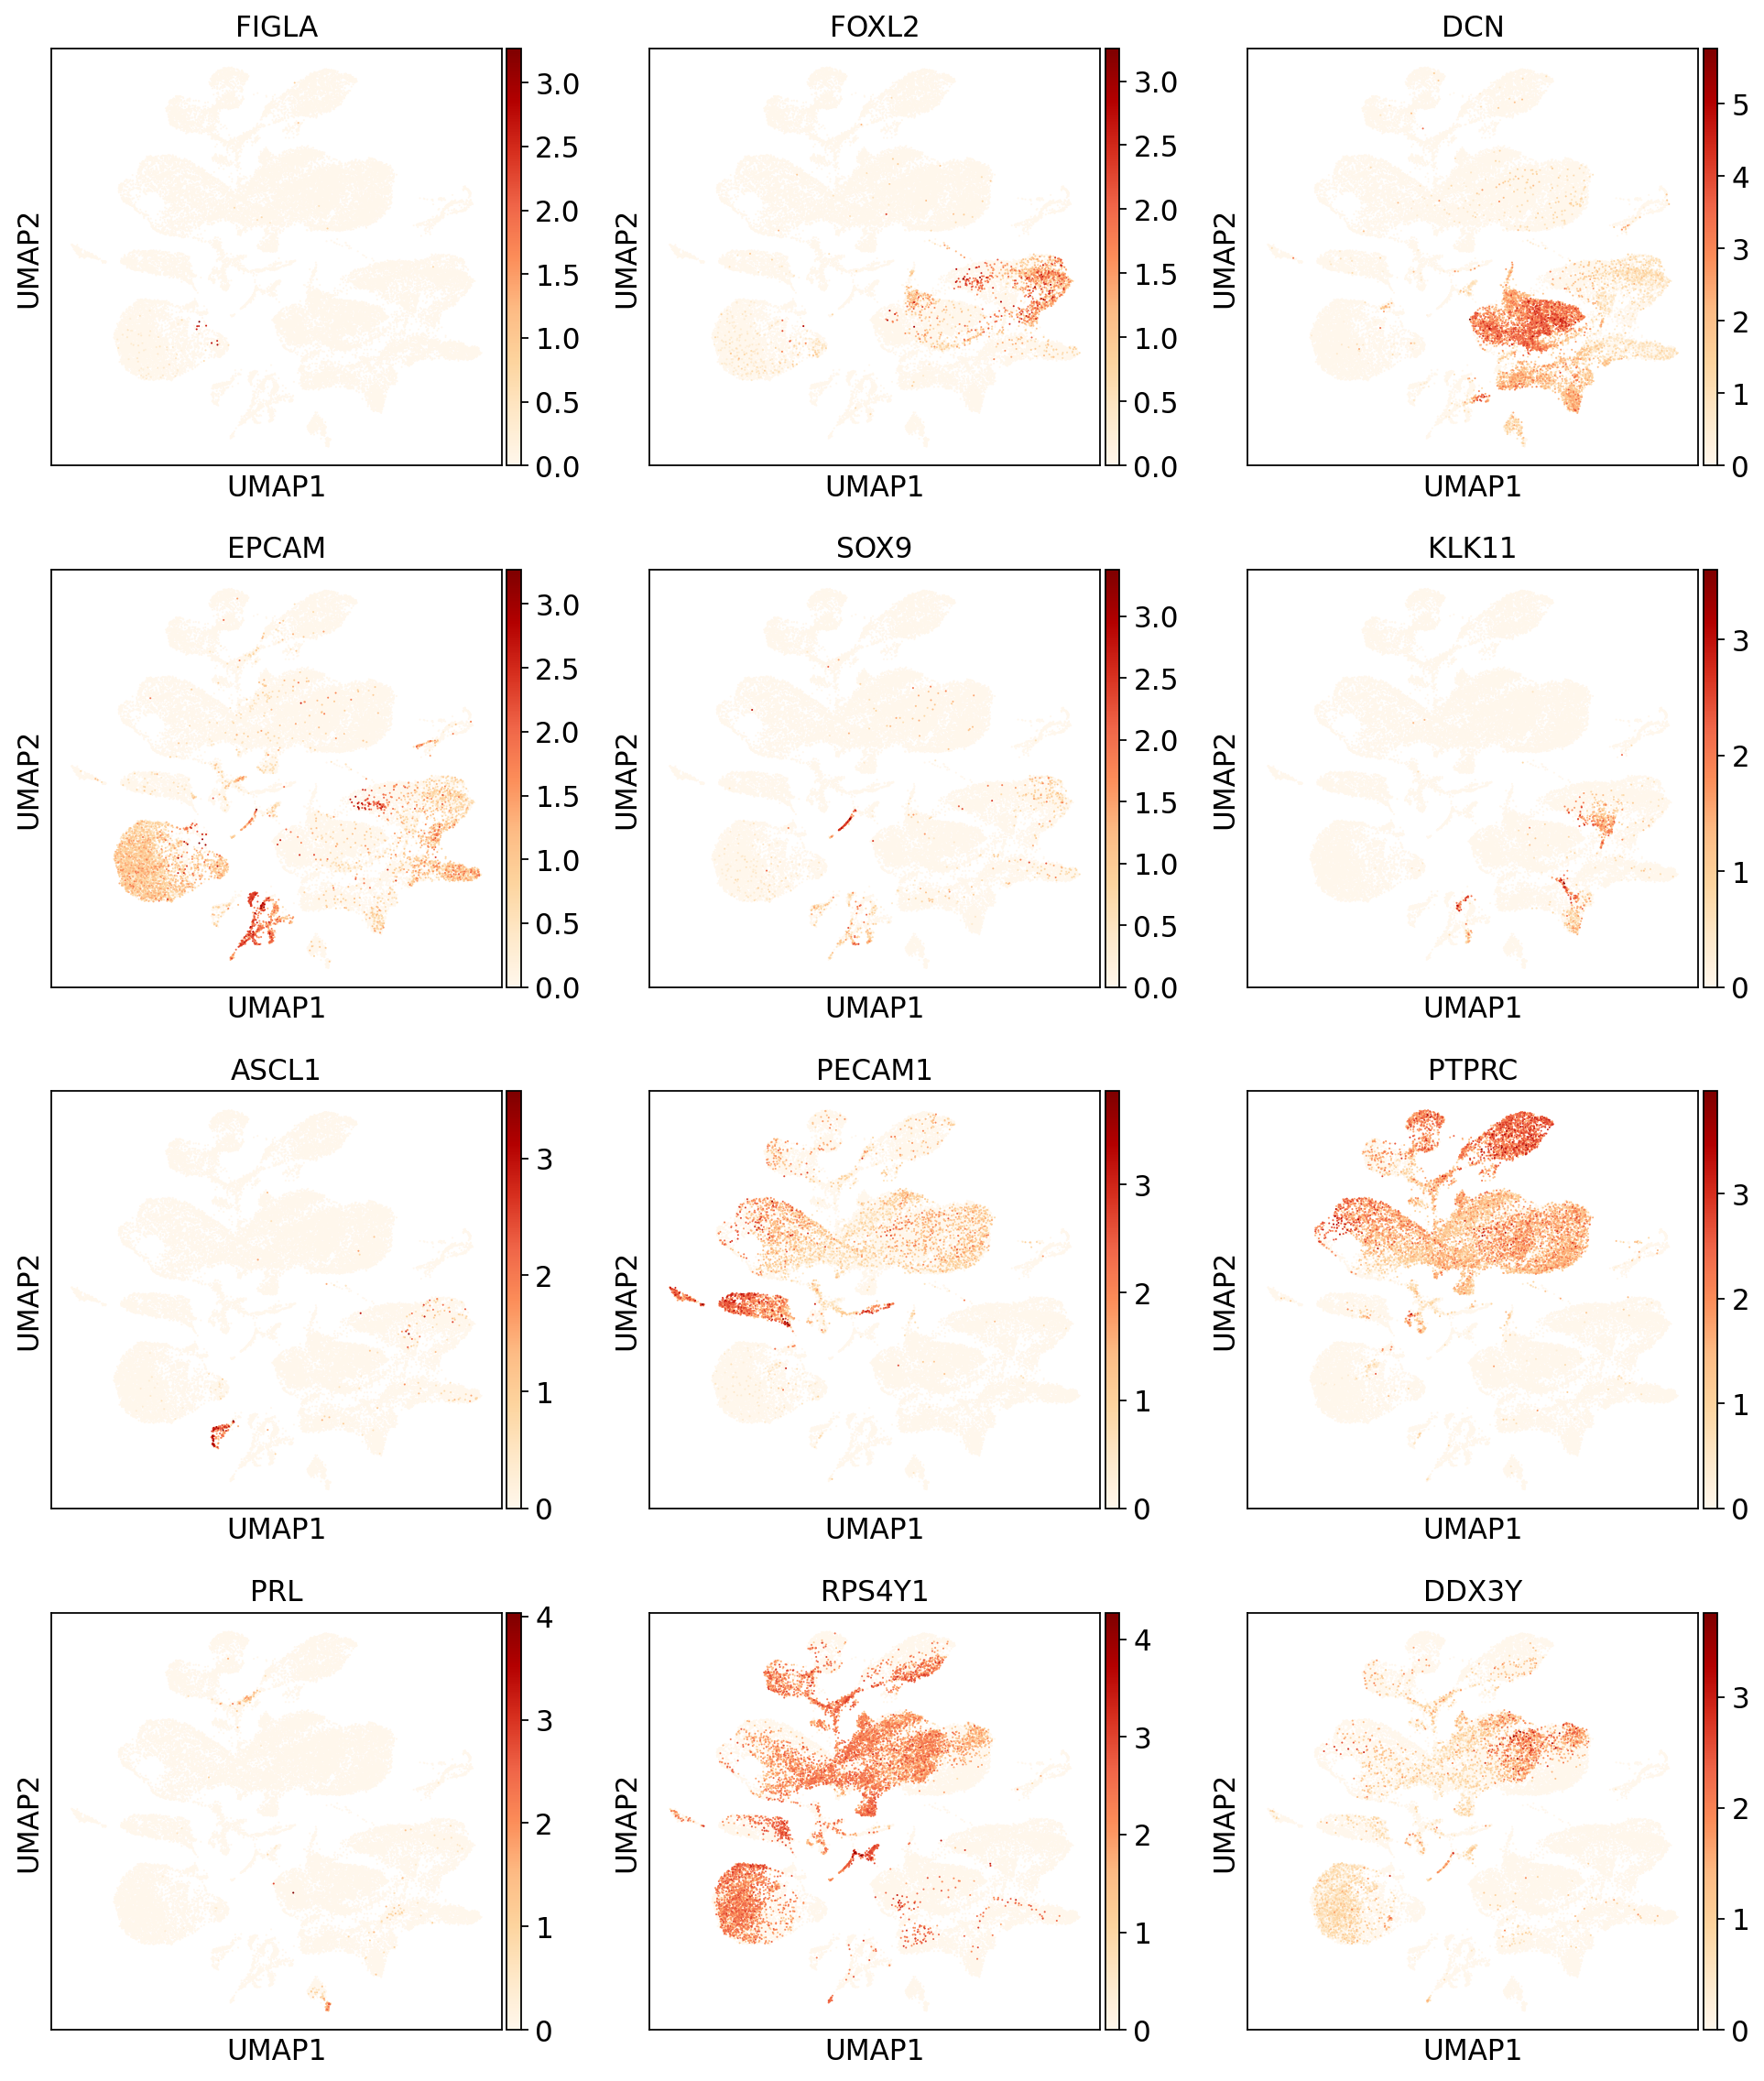

In [38]:
sc.pl.umap(adata, color=["FIGLA", "FOXL2", "DCN", "EPCAM", "SOX9", 'KLK11', 'ASCL1', 'PECAM1', 'PTPRC', 
                         'PRL', 'RPS4Y1','DDX3Y'], save='_predoublet-markers_global.pdf',
           color_map='OrRd', use_raw=False, ncols = 3)

#### End of notebook 